http://blog.ezyang.com/2019/05/pytorch-internals/

In [129]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# Read dataset
path_in = "../data/names.txt"
with open(path_in, 'r') as fh:
    words = fh.read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [126]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # rolling window
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(words)
list(zip(X, Y))[:10]

[(tensor([0, 0, 0]), tensor(5)),
 (tensor([0, 0, 5]), tensor(13)),
 (tensor([ 0,  5, 13]), tensor(13)),
 (tensor([ 5, 13, 13]), tensor(1)),
 (tensor([13, 13,  1]), tensor(0)),
 (tensor([0, 0, 0]), tensor(15)),
 (tensor([ 0,  0, 15]), tensor(12)),
 (tensor([ 0, 15, 12]), tensor(9)),
 (tensor([15, 12,  9]), tensor(22)),
 (tensor([12,  9, 22]), tensor(9))]

In [6]:
# initialize weights, the embeddings dim will be 2
C = torch.randn(27, 2)

In [7]:
# equivalent: matrix multiplication of one-hot by weights matrix AND direct indexing -> indexing is quicker
F.one_hot(torch.tensor(5), num_classes=27).float() @ C, C[5]

(tensor([ 1.2394, -0.8441]), tensor([ 1.2394, -0.8441]))

In [8]:
# indexing in PyTorch: request 1-dim tensor
C[torch.tensor([4,5,6,6,6,6])]

tensor([[-1.0537,  0.2030],
        [ 1.2394, -0.8441],
        [-0.2589,  0.1816],
        [-0.2589,  0.1816],
        [-0.2589,  0.1816],
        [-0.2589,  0.1816]])

In [9]:
X.shape, C[X].shape  # broadcasting across each data entry, for matrix multiplication

(torch.Size([228146, 3]), torch.Size([228146, 3, 2]))

In [10]:
X[13, 2]  # 13th example, last item of context is 'a' == 1

tensor(1)

In [11]:
C[1]  # weights for that item of vocab

tensor([0.3635, 0.8996])

In [12]:
C[X][13, 2]  # same weights 

tensor([0.3635, 0.8996])

In [13]:
# embeddings
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
W1 = torch.randn((2 * 3, 100))  # 2=dim of embeddings, 3=num of inputs, 100=num neurons
b1 = torch.randn(100)  # 100=num neurons

In [15]:
# transform inputs of 
# emb.shape # torch.Size([228146, 3, 2])
# to be multipliable by weights matrix 
# W1.shape # torch.Size([6, 100])
# target: emb.shape [228146, 6]
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [16]:
torch.cat(torch.unbind(emb, 1), 1).shape # unbind = remove that dimension and put its contents in tuple
# allocates new memory

torch.Size([228146, 6])

In [17]:
emb.view(-1, 6).shape # extremely efficient
# emb.storage() is an underlying PyTorch structure, a 1-dim vector
# reuses that memory

torch.Size([228146, 6])

In [18]:
# hidden states
h = emb.view(-1, 6) @ W1 + b1  # addition is broadcasted
h = torch.tanh(h)
h.shape

torch.Size([228146, 100])

In [19]:
# 2nd layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [21]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [22]:
prob.sum(1) # normalized probabilities

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [23]:
prob[torch.arange(prob.shape[0]), Y] # current predictions probs for actual Ys

tensor([7.9755e-08, 3.4198e-07, 2.2829e-07,  ..., 1.1373e-05, 5.9416e-05,
        1.6437e-08])

In [24]:
# negative log likelihood
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(17.8698)

In [110]:
# rewrite
g = torch.Generator().manual_seed(123)
C = torch.randn((27, 2), generator=g) # 
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [26]:
sum(p.nelement() for p in parameters)

3481

In [36]:
# forward pass
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(emb.shape[0]), Y].log().mean()
loss

tensor(2.7296, grad_fn=<NegBackward0>)

In [28]:
F.cross_entropy(logits, Y) # same thing but efficient

tensor(16.1605)

In [29]:
# issue with out impl of cross entropy:
# exploding exp value for large positive arguments
logits = torch.tensor([-100, -3, 0, 5, 100])
counts = logits.exp()
prob = counts / counts.sum()
counts, prob

(tensor([3.7835e-44, 4.9787e-02, 1.0000e+00, 1.4841e+02,        inf]),
 tensor([0., 0., 0., 0., nan]))

In [30]:
logits = torch.tensor([-100, -3, 0, 5, 100]) - 100 # adding any number doesn't change the value of probs, so in F.cross_entropy PyTorch will subtract the largest value in the tensor
counts = logits.exp()
prob = counts / counts.sum()
counts, prob

(tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 5.5211e-42, 1.0000e+00]),
 tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 5.5211e-42, 1.0000e+00]))

In [78]:
for i in range(100):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    if i % 10 == 0:
        print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -1 * p.grad

# slow if we process full dataset in each step -> make minibatches
# the gradient does not represent all data, but it's good enough

0 16.551145553588867
10 12.045056343078613
20 20.099708557128906
30 7.986669063568115
40 18.35965347290039
50 8.700565338134766
60 15.295694351196289
70 14.074464797973633
80 10.03425407409668
90 13.989511489868164


In [47]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(X, Y) # loss on all examples, not minibatch

tensor(2.6607, grad_fn=<NllLossBackward0>)

In [79]:
logits.max(1)[:20] # predictions probs and theis ids

(tensor([25.8367, 23.0989, 50.8898, 41.7762, 52.0210, 28.1171, 38.6095, 43.9175,
          8.4460, 60.6576, 58.2323, 60.8401, 45.7144, 38.9445,  8.4460, 47.7678,
         54.5515, 34.6912, 34.4587, 26.3666, 39.4091,  8.4460, 55.8195, 49.7977,
         57.1311, 51.1057, 55.5997, 81.5272, 45.9553, 35.5411, 26.3214, 37.4817],
        grad_fn=<MaxBackward0>),
 tensor([ 1, 22,  5,  0,  9,  1,  0, 15, 20,  0, 25,  5,  0,  0, 20, 25,  1, 14,
          1,  1, 12, 20,  0,  0,  0,  0, 14,  2, 14,  1,  1,  1]))

In [81]:
Y[:20]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2])

In [103]:
lre = torch.linspace(-3, 0, 1000) # exponent of (0.001, 1)
lrs = 10**lre # values to search over
lrs[:100]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020])

In [124]:
# experiment: save losses for each lr and find lr for min loss
lri = []
lossi = []

for i in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    if i % 100 == 0:
        print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())
    

0 15.691579818725586
100 14.08572769165039
200 10.841522216796875
300 12.245296478271484
400 5.9476118087768555
500 4.503006935119629
600 4.263204097747803
700 3.6370038986206055
800 3.5602962970733643
900 5.073049545288086


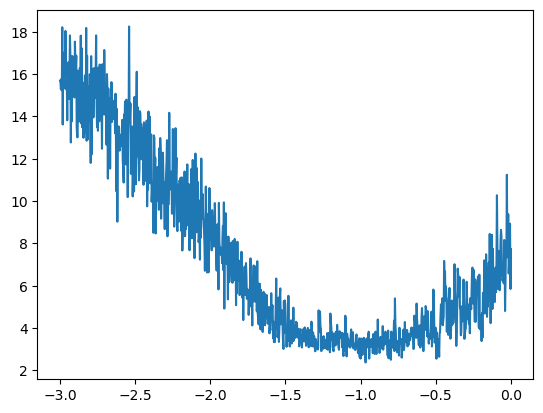

In [125]:
plt.plot(lri, lossi) # min loss would be a good learning rate -> 10**min(f(x)) -> 10**-1 = 0.1
# would be more reliable if weights weren't updated during the experiment?

In [123]:
# refresh
g = torch.Generator().manual_seed(123)
C = torch.randn((27, 2), generator=g) # 
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [119]:
# experiment: save losses for each lr and find lr for min loss
for i in range(10000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    if i % 500 == 0:
        print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Y) # loss on all examples, not minibatch

# weight decay = lower lr 10-fold at later stages

0 2.20938777923584
500 2.4098715782165527
1000 2.3328802585601807
1500 2.033841371536255
2000 2.3592300415039062
2500 2.277062177658081
3000 2.218859910964966
3500 1.8628158569335938
4000 2.3710570335388184
4500 2.1305365562438965
5000 2.058462619781494
5500 1.9397095441818237
6000 2.390530586242676
6500 1.9020596742630005
7000 2.1144931316375732
7500 2.353661060333252
8000 2.059011936187744
8500 2.486910820007324
9000 2.4450857639312744
9500 2.2446324825286865


tensor(2.3087, grad_fn=<NllLossBackward0>)

In [130]:
# preventing overfitting -> dataset split
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Ytr.shape, Xval.shape, Yval.shape, Xte.shape, Yte.shape, 

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [150]:
# refresh
g = torch.Generator().manual_seed(123)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # scaling up
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
lossi = []
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

10281

In [157]:
# if eval loss is similar to train loss, then model is not overfitting
# actually it's underfitting, so we can scale up the nn params
# and increase batch size to reduce noise
for i in range(10000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    if i % 500 == 0:
        print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())

emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Yval) 

0 2.4730026721954346
500 2.5871005058288574
1000 2.4980905055999756
1500 2.4576210975646973
2000 2.258915901184082
2500 2.2408547401428223
3000 1.9731731414794922
3500 2.344421625137329
4000 2.2323355674743652
4500 2.4756977558135986
5000 2.593933343887329
5500 2.373948097229004
6000 2.5808346271514893
6500 2.0863840579986572
7000 2.8625600337982178
7500 2.211517333984375
8000 2.245234489440918
8500 1.9865847826004028
9000 1.9165425300598145
9500 2.328720808029175


tensor(2.3062, grad_fn=<NllLossBackward0>)

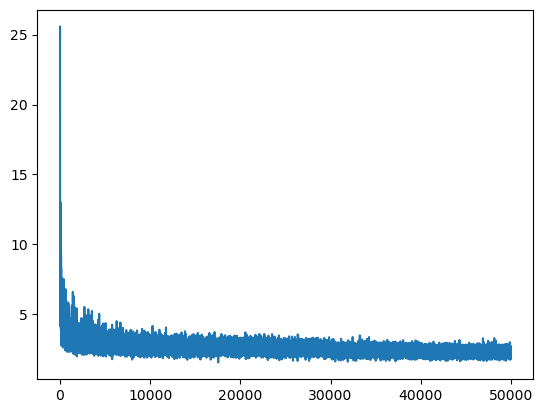

In [158]:
plt.plot(torch.arange(len(lossi)), lossi)
# mini batches create noise

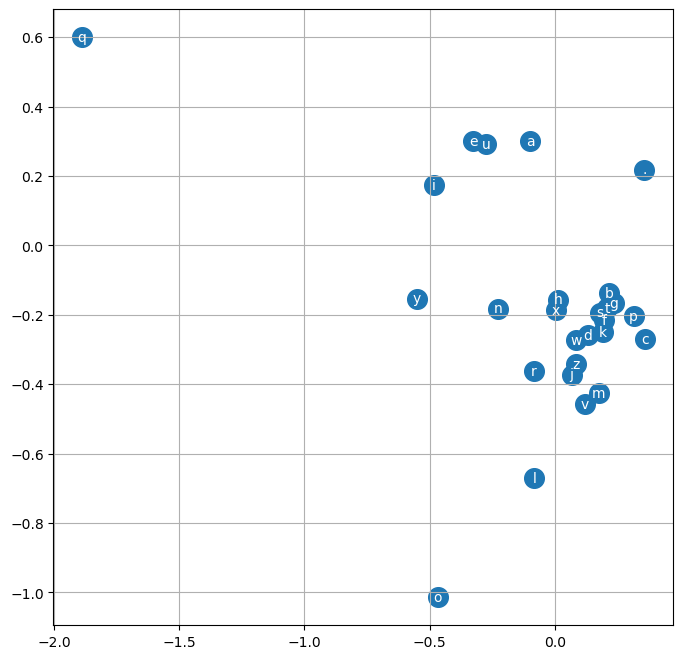

In [160]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
# vowels are clustering - similar ~ interchangeable
# q is quite exceptional
# . is separate

In [162]:
# refresh
g = torch.Generator().manual_seed(123)
C = torch.randn((27, 10), generator=g) # larger embeddings
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
lossi = []
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

In [ ]:
for i in range(100000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    if i % 500 == 0:
        print(i, loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.log10().item())

emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
F.cross_entropy(logits, Yval) 

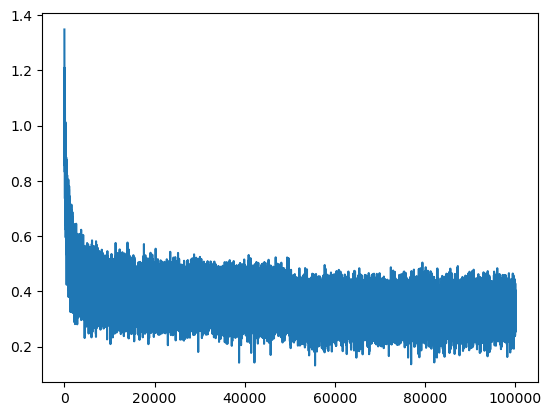

In [169]:
plt.plot(torch.arange(len(lossi)), lossi)

In [172]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jaislhe.
mylianna.
ganchemih.
alah.
anon.
yuno.
leigh.
ahlee.
cadequayah.
kero.
perrice.
fryn.
izukaih.
ten.
ria.
treysan.
lophae.
avarlinylejayelanyana.
syaan.
dwy.
